In [2]:
import os
import numpy as np
import pandas as pd
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import log_loss

In [3]:
!pwd

/home/imported


# Define Functions & Global Variables

### Fixed Variables

In [4]:
COL_TARGET = 'target'
COL_ID = 'id'
IN_DIR = '../input/otto-group-product-classification-challenge'
TEST_FILE = os.path.join(IN_DIR, 'test.csv')
TRAIN_FILE = os.path.join(IN_DIR, 'train.csv')
SAMPLE_SUBMISSION_FILE = os.path.join(IN_DIR, 'sampleSubmission.csv')

### Functions

In [21]:
def detach_target(raw_data):
    d = raw_data.copy()
    return raw_data.drop([COL_TARGET], axis=1), d[COL_TARGET]
    

target_enc = LabelEncoder()


feature_pipeline = Pipeline([
    ('scaling', StandardScaler()),
])


preprocessor = ColumnTransformer(transformers=[
    ('feature_transform', feature_pipeline, slice(1, 94)),
    ('remove_id', 'drop', [COL_ID]),
], remainder='drop')


def preprocess_data(data):
    return preprocessor.transform(data)


def make_output(model, test_data, ids, file_name='submission.csv'):
    pred = model.predict_proba(test_data)
    
    out = pd.DataFrame(pred, columns=['Class_' + str(i) for i in range(1, 10)])
    out.insert(loc=0, column='id', value=ids)
    out.to_csv(file_name, index=False)
    print(f'Written submission file to: {file_name}')
    
    
def train_xgboost(train_data, train_targets, val_data, val_targets):
    model = XGBClassifier(n_estimators=500, learning_rate=0.05, n_jobs=4)
    model.fit(train_data, train_targets, early_stopping_rounds=10, eval_set=[(val_data, val_targets)])
    return model


def train_gridsearch(train_data, targets):
    # experiment k-fold
    xgb_model = XGBClassifier(
            learning_rate=0.05,
            objective='multi:softprob')

    test_params = {
        'n_estimators': [100, 500, 900],
        'max_depth': [5, 7],
    }

    # define k-fold validation set
    kfold = KFold(n_splits=5, shuffle=True)

    cv_model = GridSearchCV(
        estimator=xgb_model, 
        param_grid=test_params, 
        cv=kfold, 
        n_jobs=8,
        verbose=2, 
        refit=True)

    cv_model.fit(train_data, targets)
    return cv_model


def score_model(model, data, targets):
    # test on validation set
    prds = model.predict_proba(data)
    return log_loss(targets, prds)

## Read Raw Data

In [6]:
train_data_raw, train_target_raw = detach_target(pd.read_csv(TRAIN_FILE))
test_data_raw = pd.read_csv(TEST_FILE)

# Show Example Output
(For reference)

In [7]:
sample_out_data = pd.read_csv(SAMPLE_SUBMISSION_FILE)
sample_out_data.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,1,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0


# Exploring Data

Train Data: 61878 x 95

Test Data : 144368 x 94

In [9]:
print(train_data_raw.shape)
train_data_raw.head()

(61878, 94)


,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,6,1,5,0,0,...,22,0,1,2,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [10]:
print(train_target_raw.shape)
train_target_raw.head()

(61878,)


0    Class_1
1    Class_1
2    Class_1
3    Class_1
4    Class_1
Name: target, dtype: object

In [11]:
print(test_data_raw.shape)
test_data_raw.head()

(144368, 94)


,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,...,0,0,11,1,20,0,0,0,0,0
1,2,2,2,14,16,0,0,0,0,0,...,0,0,0,0,0,4,0,0,2,0
2,3,0,1,12,1,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
3,4,0,0,0,1,0,0,0,0,0,...,0,3,1,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,1,2,0,...,0,0,0,0,0,0,0,9,0,0


# Feature Preprocessing

In [12]:
# fit data preprocessor
preprocessor = preprocessor.fit(train_data_raw)

## Input Feature Preprocessing

In [13]:
# preprocess train data
X_train = preprocess_data(train_data_raw)
X_train.shape

(61878, 93)

In [14]:
# preprocess test data
X_test = preprocess_data(test_data_raw)
X_test.shape

(144368, 93)

In [15]:
# preprocess train label
y_train = target_enc.fit_transform(train_target_raw)
target_enc.classes_

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

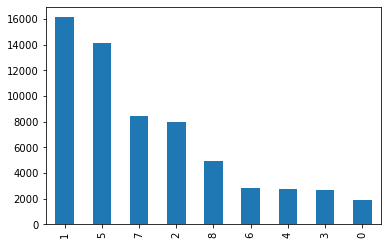

In [16]:
# show distribution of targets
pd.DataFrame(y_train)[0].value_counts().plot.bar()

very unbalanced target - very few 0s, large number of 1s and 5s

In [17]:
# see null values
print(pd.DataFrame(X_train).isnull().sum().sum())
print(pd.DataFrame(X_test).isnull().sum().sum())

0
0


# Split Dataset

In [18]:
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=9123)

In [ ]:
model = train_gridsearch(X_train, y_train)
print(score_model(model, X_va, y_va))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


In [20]:
# create a submission file
make_output(model, X_test, ids=test_data_raw.id)

Written submission file to: submission.csv
